# Часть 2. Исследование игроков игрового события.

#### 1. Проведите первичный разведывательный анализ: что характерного можно сказать об этих данных? Какие выводы об игроках можно сделать?

Разведовательный анализ - один из самых важных этапов, который позволяет узнать данные, сделать первые выводы, идентифицировать интересные тренды и подготовить данные для последующих этапов работы.

In [1]:
# Подгрузка библиотек
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
sns.set_theme(style="ticks")

%matplotlib inline

In [2]:
player_info = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-murzakova/PK/df_test_assignment.csv', sep = ';')
player_info.head()

,player_id,level,battle_pass_points,rating_points,clan_members,clan_type
0,10230768776,232,1000,87,20,public
1,9139343274,60,85,1,6,public
2,10776746942,34,65,3,0,NaN
3,8217817598,240,1000,46,20,non-public
4,10766546068,73,755,49,0,NaN


In [3]:
player_info.tail()

,player_id,level,battle_pass_points,rating_points,clan_members,clan_type
4965,10502542618,203,780,1,0,NaN
4966,10735019562,112,1000,161,19,public
4967,6057997640,125,1000,5,0,NaN
4968,10040382618,160,850,79,20,public
4969,7785646768,244,1000,126,20,public


Датасет содержит следующие поля:

● player_id - идентификатор игрока (уникален для игрока)

● level - уровень игрока

● battle_pass_points - очки опыта (в рамках баттл пасса) к концу игрового события

● rating_points - очки рейтинга к концу игрового события

● clan_members - кол-во игроков в клане (если игрок состоит в клане)

● clan_type - тип клана, в котором состоит игрок (если состоит в клане)

Прочитав датасет, приятно отметить, что столбцы названы в удобном формате (без пробелов, везде нижний регистр), более того, у нас имеется описание переменных, что позволяет сразу приступить к разведочному анализу.

In [4]:
player_info.shape # Посмотрим на размер датасета

(4970, 6)

In [5]:
player_info.dtypes # Проверим типы переменных

player_id              int64
level                  int64
battle_pass_points     int64
rating_points          int64
clan_members           int64
clan_type             object
dtype: object

In [6]:
player_info.describe() # Описательная статистика

,player_id,level,battle_pass_points,rating_points,clan_members
count,4.970000e+03,4970.000000,4970.000000,4970.000000,4970.000000
mean,9.128778e+09,134.741650,549.486922,61.857746,6.434205
std,2.116932e+09,73.477994,370.306257,119.494481,7.825026
min,3.862934e+09,9.000000,0.000000,0.000000,0.000000
25%,9.117998e+09,69.000000,180.000000,5.000000,0.000000
50%,9.976645e+09,139.000000,575.000000,23.000000,2.000000
75%,1.065426e+10,189.000000,1000.000000,59.000000,14.000000
max,1.080070e+10,544.000000,1000.000000,1780.000000,20.000000


In [7]:
player_info.isna().sum() # Посмотрим, есть ли в каких-либо столбцах пропущенные значения

player_id                0
level                    0
battle_pass_points       0
rating_points            0
clan_members             0
clan_type             2406
dtype: int64

In [8]:
player_info.groupby('clan_type', as_index = False).player_id.count().rename(columns={'player_id':'player_id_count'})
# Посмотрим, какая информация хранится в столбце clan_type

,clan_type,player_id_count
0,non-public,602
1,private,135
2,public,1827


In [9]:
player_info = player_info.fillna('not_in_clan') # Заменим пропущенные значения, чтобы в дальнейшем удобнее было группировать

In [10]:
# Проверим, все ли id игроков уникальные, хотя в описаннии переменных было уточнение про уникальность
if player_info.player_id.nunique() == player_info.shape[0]:
    print('Unique player_id')
else:
    print('Non-unique player_id')

Unique player_id


Мы начали знакомство с данными, теперь было бы интересно оценить, есть ли взаимодействия между переменными датасета. Построим попарный график sketterplot для всех характеристик игроков, возможно, уже увидим линейные взаимосвязи переменных.

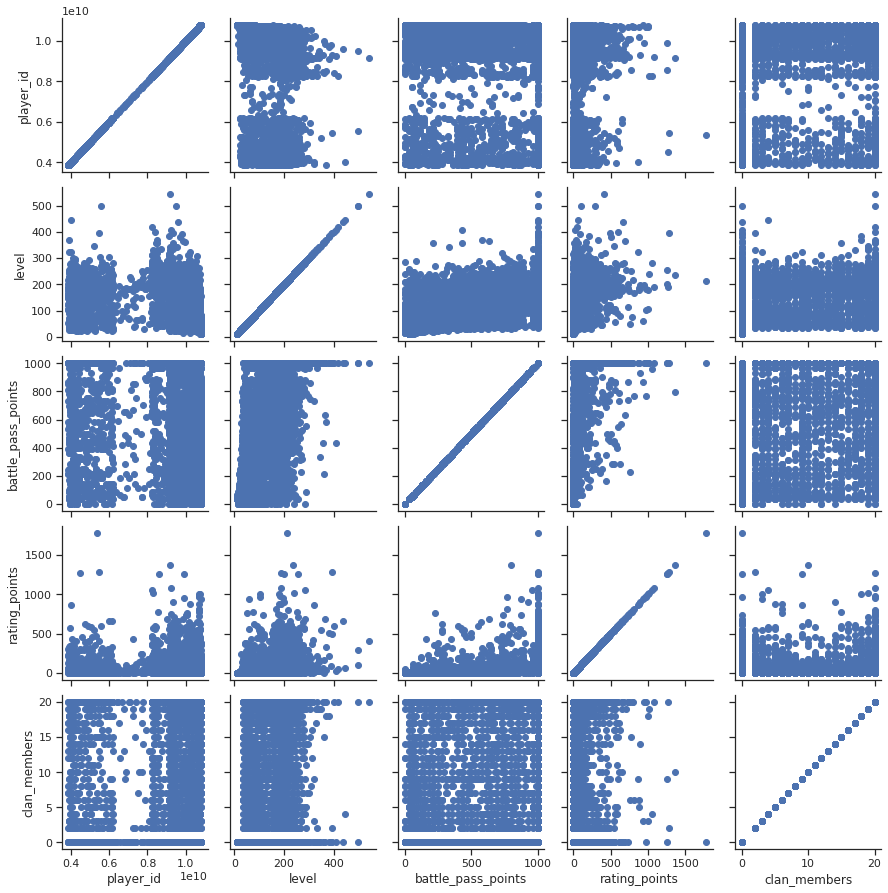

In [11]:
pair_grid_plot = sns.PairGrid(player_info)
pair_grid_plot.map(plt.scatter);

На получившихся графиках сложно выявить, между какими характеристиками существует линейная зависимость, поэтому давайте рассчитаем корреляцию в числовых значениях.

In [12]:
player_info.corr()

,player_id,level,battle_pass_points,rating_points,clan_members
player_id,1.000000,-0.313372,-0.129136,-0.045039,-0.047749
level,-0.313372,1.000000,0.612778,0.316423,0.285162
battle_pass_points,-0.129136,0.612778,1.000000,0.415066,0.352903
rating_points,-0.045039,0.316423,0.415066,1.000000,0.218928
clan_members,-0.047749,0.285162,0.352903,0.218928,1.000000


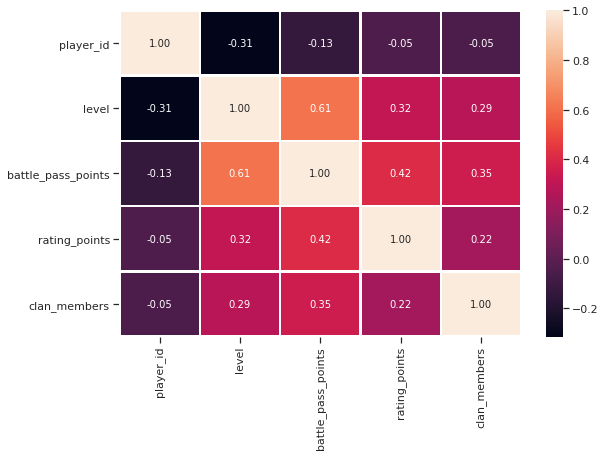

In [13]:
f,ax = plt.subplots(figsize=(9,6)) # Построим тепловую карту
sns.heatmap(player_info.corr(), annot = True, linewidths=1.5 , fmt = '.2f',ax=ax)
plt.show()

На графике мы видим, что корреляция была обнаружена между несколькими характеристиками. Давайте более детально рассмотрим выявленные взаимосвязи, будем двигаться от большей корреляции к меньшей.

#### 1. level и battle_pass_points

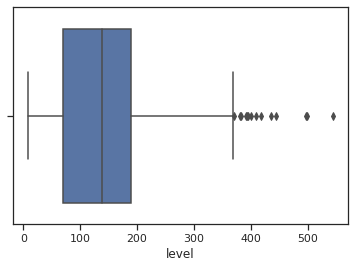

In [14]:
sns.boxplot(data = player_info, x = 'level'); # Распределение показателя уровня игроков

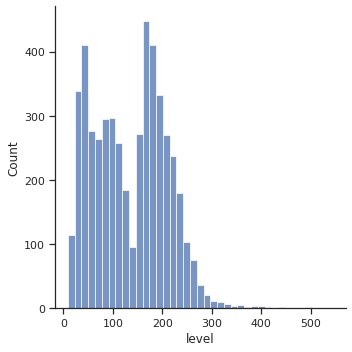

In [15]:
sns.displot(player_info.level, kde = False); # Распределение показателя уровня игроков

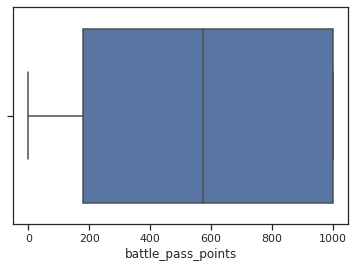

In [16]:
sns.boxplot(data = player_info, x = 'battle_pass_points'); # Распределение очков опыта

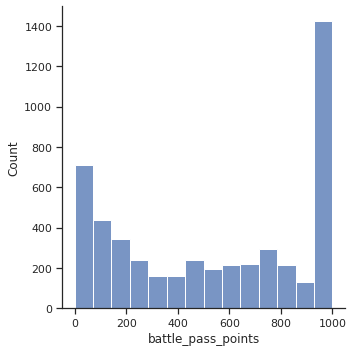

In [17]:
sns.displot(player_info.battle_pass_points, kde = False); # Распределение очков опыта

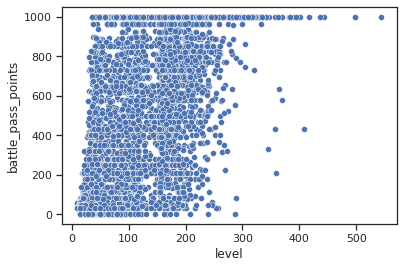

In [18]:
sns.scatterplot(x = 'level', y = 'battle_pass_points', data = player_info);

При постоении графиков распределения уровня игроков мы увидели, что данные скошены в левую часть и имеют существенные выбросы: медианное значение - 139 уровень, 75% игроков имеют уровень ниже или равный 189 уровню, хотя максимальное значение достигает 544 уровня. Давайте попробуем построить график без выбросов (ограничим 350 уровнем) и посмотрим, изменится ли как-то визуальная взаимосвязь.

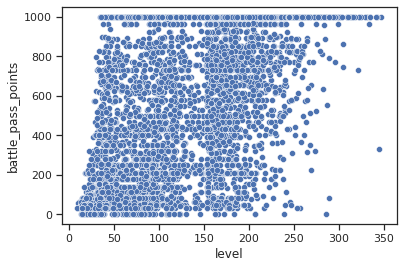

In [19]:
sns.scatterplot(x = 'level', y = 'battle_pass_points', data = player_info[player_info.level < 350]);

Визуально кажется, что корреляция стала более просматриваемой. Давайте попробуем еще один вариант - преобразуем - прологорифмируем данные и проверим распределение и взаимосвязь.

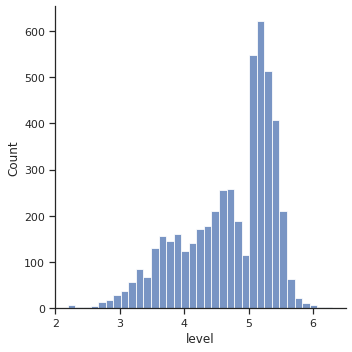

In [20]:
sns.displot(np.log(player_info.level), kde = False) # Прологорифмированное распределение уровня игроков

In [21]:
player_info['level_log'] = np.log(player_info.level)
player_info.head()

,player_id,level,battle_pass_points,rating_points,clan_members,clan_type,level_log
0,10230768776,232,1000,87,20,public,5.446737
1,9139343274,60,85,1,6,public,4.094345
2,10776746942,34,65,3,0,not_in_clan,3.526361
3,8217817598,240,1000,46,20,non-public,5.480639
4,10766546068,73,755,49,0,not_in_clan,4.290459


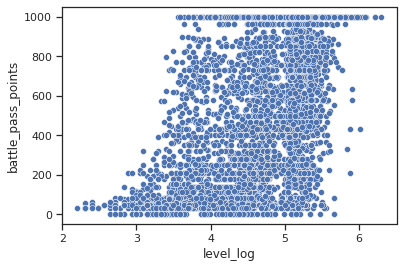

In [22]:
sns.scatterplot(x = 'level_log', y = 'battle_pass_points', data = player_info);

На получившемся графике корреляция стала визуально более просматриваемой. Давайте проверим корреляцию с помощью параметрического и непараметрических методов.

In [23]:
st.pearsonr(player_info.level, player_info.battle_pass_points) # Даёт значение коэффициента корреляции и p-значение ПАРАМЕТРИЧЕСКИЙ

(0.6127776298118134, 0.0)

In [24]:
st.spearmanr(player_info.level, player_info.battle_pass_points) # НЕПАРАМЕТРИЧЕСКИЙ МЕТОД

SpearmanrResult(correlation=0.6329000412785132, pvalue=0.0)

#### Вывод: 
Оба метода выявили взаимосвязь между уровнем игроков в конце игрового события и очками опыта, накопленными в рамках баттл пасса. В распределении значений уровня были обнаружены существенные выбросы, а выбросы нам интересны, так как, возможно, данные игроки, это "киты", которые лояльны к нашей игре, долго играют, приносят большее количество денег, поэтому мы можем потенциально данным игрокам выдать специальные офферы, проявить дополнительную лояльность.

Далее используем такие же действиями, чтобы проверить следующие характеристики игроков.

#### 2. battle_pass_points и rating_points

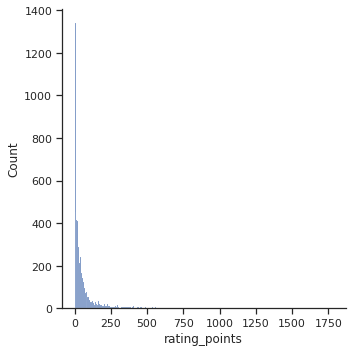

In [25]:
sns.displot(player_info.rating_points, kde = False); # Распределение очков рейтинга, сильно скошено влево, большой "хвост" выбросов

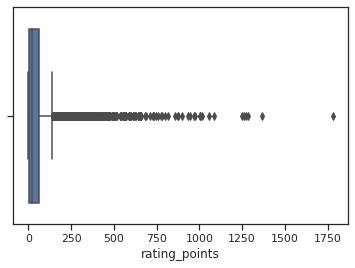

In [26]:
sns.boxplot(data = player_info, x = 'rating_points'); # Очень большое количество выбросов

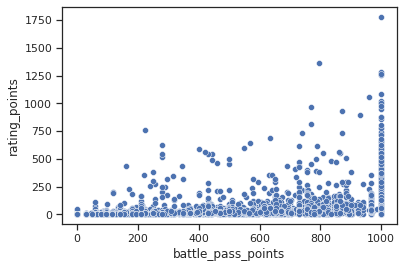

In [27]:
sns.scatterplot(x = 'battle_pass_points', y = 'rating_points', data = player_info);

Как и в предыдущем пункте постоим график, удалив выбросы, посмотрим, изменится ли представление.

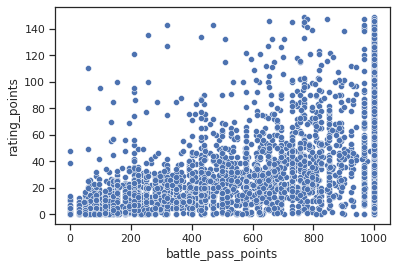

In [28]:
sns.scatterplot(x = 'battle_pass_points', y = 'rating_points', data = player_info[player_info.rating_points < 150]);

In [29]:
st.pearsonr(player_info.battle_pass_points, player_info.rating_points) # Даёт значение коэффициента корреляции и p-значение ПАРАМЕТРИЧЕСКИЙ

(0.41506591441358776, 2.871790032344418e-206)

In [30]:
st.spearmanr(player_info.battle_pass_points, player_info.rating_points) # НЕПАРАМЕТРИЧЕСКИЙ МЕТОД

SpearmanrResult(correlation=0.7705190254641608, pvalue=0.0)

#### Вывод: 
Оба теста выявили зависимость между очками опыта и очками рейтинга, а непараметрический тест выявил корреляцию - 0.77. В распределении очков рейтинга также наблюдатся большие выбросы, на которые стоит обратить внимание, так как данные игроки, скорее всего лояльны к нашему продукту, много играют, чтобы зарабатывать очки рейтинга.

#### 3. battle_pass_points и clan_members

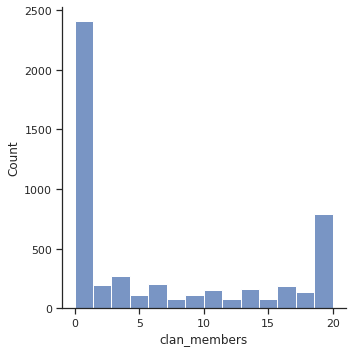

In [31]:
sns.displot(player_info.clan_members, kde = False);

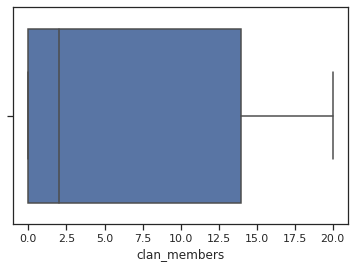

In [32]:
sns.boxplot(data = player_info, x = 'clan_members');

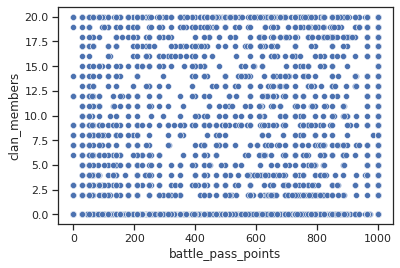

In [33]:
sns.scatterplot(x = 'battle_pass_points', y = 'clan_members', data = player_info);

In [34]:
st.pearsonr(player_info.battle_pass_points, player_info.clan_members) # Даёт значение коэффициента корреляции и p-значение ПАРАМЕТРИЧЕСКИЙ

(0.3529033493112159, 1.0461513060685718e-145)

In [35]:
st.spearmanr(player_info.battle_pass_points, player_info.clan_members) # НЕПАРАМЕТРИЧЕСКИЙ МЕТОД

SpearmanrResult(correlation=0.37413475229876897, pvalue=6.360666754920994e-165)

#### Вывод: 
Корреляция между количеством игроков в клане и очками опыта выявлена, но достаточно слабая. Более того, мы включали все данные по количеству игроков, включая тех, кто не состоит в клане, поэтому в данных большое количество нулевых значений, что также могло повлиять на результат. Мы дополнительно рассмотрим отдельно корреляции игроков в клане во второй части исследования, но пока можно сделать вывод, что количество человек в клане очень слабо коррелирует с количеством очков опыта.

#### 4. level и rating_points

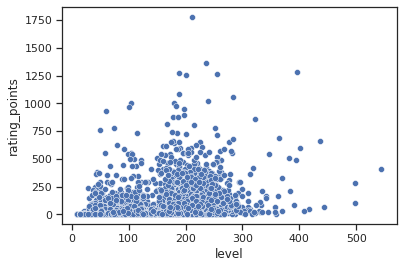

In [36]:
sns.scatterplot(x = 'level', y = 'rating_points', data = player_info);

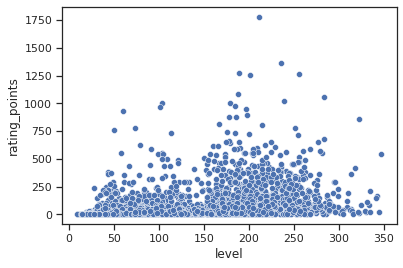

In [37]:
sns.scatterplot(x = 'level', y = 'rating_points', data = player_info[player_info.level < 350]);
# Посмотрим, изменится ли график, если убрать выбросы по уровням игроков

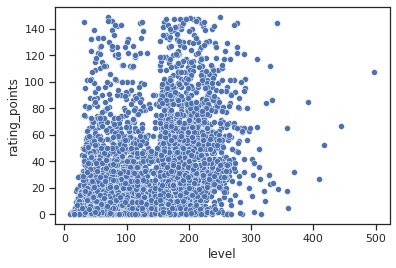

In [38]:
sns.scatterplot(x = 'level', y = 'rating_points', data = player_info[player_info.rating_points < 150]);
# Посмотрим, изменится ли график, если убрать выбросы по очкам рейтинга

In [39]:
st.pearsonr(player_info.level, player_info.rating_points) #даёт значение коэффициента корреляции и p-значение ПАРАМЕТРИЧЕСКИЙ

(0.3164234818928761, 5.530227998308857e-116)

In [40]:
st.spearmanr(player_info.level, player_info.rating_points) # НЕПАРАМЕТРИЧЕСКИЙ МЕТОД

SpearmanrResult(correlation=0.5102107728594788, pvalue=0.0)

#### Вывод: 
Непараметрический тест выявил больший коэффициент корреляции (0.5), чем параметрический (0.3), положительная взаимосвязь между уровнем игроков и очками рейтинга обнаружена, хотя и не очень сильная.

In [41]:
# Для общего вывода посчитаем, какое процентное соотношение игроков состоит и не состоит в клане
player_info_by_clan = player_info.groupby('clan_type', as_index = False).player_id.count().rename(columns={'player_id':'player_id_count'})
player_info_by_clan

,clan_type,player_id_count
0,non-public,602
1,not_in_clan,2406
2,private,135
3,public,1827


In [42]:
# Переведем в проценты
player_info_by_clan['player_id_count_%'] = np.round(player_info_by_clan.player_id_count / player_info_by_clan.player_id_count.sum() * 100)
player_info_by_clan 

,clan_type,player_id_count,player_id_count_%
0,non-public,602,12.0
1,not_in_clan,2406,48.0
2,private,135,3.0
3,public,1827,37.0


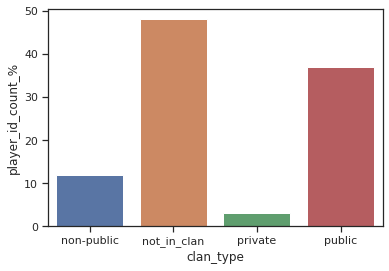

In [43]:
sns.barplot(data = player_info_by_clan, x = 'clan_type', y = 'player_id_count_%')

#### Общий вывод:

Исследуемые игроки:
1. Большая часть исследуемых игроков (75%) играют в диапазоне от 9 до 189 уровня, только 25% игроков прошли дальше, хотя максимальный уровень - 544. Распределение уровня игроков показало большие выбросы, на которые стоит обратить внимание, так как это могут быть лояльные игроки продукта;
2. В среднем игроки набирают 550 очков в рамках баттл пасса, 25% игроков имеют максимальное количество очков - 1000;
3. 75% игроков имеют очки рейтинга меньше или равно 59, в то время как максимальное количество очков достигает 1780 (опять стоит обратить внимание на игроков, которые уделяют много времени игре, продвижению в рейтинге;
4. 48% игроков не состоит в кланах. Более внимательно данную характеристику мы рассмотрим во второй части исследования.


В данных выявилась корреляция некоторых характеристик игроков:
1. Наиболее сильная взаимосвязь (коэффициент корреляции 0,6) обнаружилась между уровнем и очками опыта (в рамках баттл пасса) к концу игрового события. Можно предположить, что существует положительная линейная зависимость: чем выше уровень игрока, тем он больше очков набирает в рамках баттл пасса или наоборот, так как корреляция не говорит о причинно следственной связи.
2. Следующая взаимосвязь, которую удалось обнаружить: очки опыта и очки рейтинга к концу игрового события. Также наблюдается положительная корреляция (0.4 - параметрический тест, 0.8 (!) - непараметрический тест);
3. Корреляция между количеством игроков в клане и очками опыта выявлена, но достаточно слабая - на уровне 0.4. Сейчас мы анализировали все данные по количеству игроков, включая тех, кто не состоит в клане, поэтому в данных большое количество нулевых значений, что также могло повлиять на результат;
4. Непараметрический тест выявил больший коэффициент корреляции, чем параметрический, положительная взаимосвязь между уровнем игроков и очками рейтинга обнаружена, хотя и слабая.

#### 2. Попробуйте ответить на вопрос: влияет ли пребывание игрока в клане и характеристики клана на успехи игрока в игровом событии?

Для начала давайте рассмотрим показатели игроков, которые состоят и не состоят в клане. Далее посмотрим, есть ли различия между типами кланов. Создадим дополнительный столбец "in_clan" с информацией, состоит игрок в клане или нет.

In [44]:
player_info['in_clan'] = np.where(player_info['clan_type'] != 'not_in_clan', 'yes', 'no')

In [45]:
player_info.head()

,player_id,level,battle_pass_points,rating_points,clan_members,clan_type,level_log,in_clan
0,10230768776,232,1000,87,20,public,5.446737,yes
1,9139343274,60,85,1,6,public,4.094345,yes
2,10776746942,34,65,3,0,not_in_clan,3.526361,no
3,8217817598,240,1000,46,20,non-public,5.480639,yes
4,10766546068,73,755,49,0,not_in_clan,4.290459,no


In [46]:
player_info_in_clan = player_info.query('in_clan == "yes"') # Датасет с данными только по тем игрокам, которые состоят в клане
player_info_in_clan.head()

,player_id,level,battle_pass_points,rating_points,clan_members,clan_type,level_log,in_clan
0,10230768776,232,1000,87,20,public,5.446737,yes
1,9139343274,60,85,1,6,public,4.094345,yes
3,8217817598,240,1000,46,20,non-public,5.480639,yes
6,10032752836,76,500,18,20,public,4.330733,yes
8,10399914104,241,1000,80,20,non-public,5.484797,yes


In [47]:
player_info_in_clan.shape # Размеры нового датасета

(2564, 8)

In [48]:
player_info_in_clan.describe() # Описательная статистика

,player_id,level,battle_pass_points,rating_points,clan_members,level_log
count,2.564000e+03,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000
mean,9.012029e+09,155.191108,673.923557,86.512871,12.471919,4.911907
std,2.141101e+09,70.260705,348.463199,139.756106,6.586351,0.558947
min,3.862934e+09,33.000000,0.000000,0.000000,2.000000,3.496508
25%,8.681389e+09,92.000000,373.750000,14.000000,6.000000,4.521789
50%,9.872229e+09,167.000000,785.000000,39.000000,13.000000,5.117994
75%,1.059629e+10,206.000000,1000.000000,88.000000,19.000000,5.327876
max,1.079869e+10,544.000000,1000.000000,1366.000000,20.000000,6.298949


In [49]:
player_info_in_clan.corr() # Новых явных взаимосвязей не обнаружено

,player_id,level,battle_pass_points,rating_points,clan_members,level_log
player_id,1.000000,-0.299580,-0.110673,-0.038292,-0.005448,-0.297365
level,-0.299580,1.000000,0.546439,0.270805,0.135558,0.961864
battle_pass_points,-0.110673,0.546439,1.000000,0.373586,0.187345,0.556381
rating_points,-0.038292,0.270805,0.373586,1.000000,0.096970,0.246136
clan_members,-0.005448,0.135558,0.187345,0.096970,1.000000,0.123305
level_log,-0.297365,0.961864,0.556381,0.246136,0.123305,1.000000


Сгруппируем игроков по столбцу "in_clan" и посчитаем средние показатели по уровню, накопленному опыту и рейтингу к концу гровой сессии.

In [50]:
player_info.groupby('in_clan', as_index = False) \
            .agg({'player_id':'count', 'level':'mean', 'battle_pass_points':'mean', 'rating_points':'mean'}) \
            .round() \
            .rename(columns = {'player_id':'player_id_count', 'level':'level_mean', 'battle_pass_points':'battle_pass_points_mean', 'rating_points':'rating_points_mean'})

,in_clan,player_id_count,level_mean,battle_pass_points_mean,rating_points_mean
0,no,2406,113.0,417.0,36.0
1,yes,2564,155.0,674.0,87.0


В нашем датасете примерно одинаковое количество игроков как состоит, так и не состоит в клане. Можно заметить, что все показатели игроков, которые состоят в клане, более высокие. Можно предположить, что данные игроки более вовлечены в игру, им недостаточно только игры, а еще требуется общая атмосфера группы, окружение, связанное едиными интересами.

Мы помним, что распределения некоторых данных имеют большие выбросы, например, rating_points, а среднее значение очень чувствительно к выбросам, поэтому давайте сравним медианные значения.

In [51]:
player_info.groupby('in_clan', as_index = False) \
            .agg({'player_id':'count', 'level':'median', 'battle_pass_points':'median', 'rating_points':'median'}) \
            .round() \
            .rename(columns = {'player_id':'player_id_count', 'level':'level_median', 'battle_pass_points':'battle_pass_points_median', 'rating_points':'rating_points_median'})

,in_clan,player_id_count,level_median,battle_pass_points_median,rating_points_median
0,no,2406,102,320,12.0
1,yes,2564,167,785,39.0


Давайте отдельно рассмотрим метрики по типам кланов и попробуем предположить, какой тип клана показывает себя более успешным относительно других. Как и ранее, рассмотрим и средние, и медианные значения.

In [52]:
# Средние значения
player_info.query('clan_type != "not_in_clan"') \
            .groupby('clan_type', as_index = False) \
            .agg({'player_id':'count', 'level':'mean', 'battle_pass_points':'mean', 'rating_points':'mean', 'clan_members':'mean'}) \
            .round() \
            .rename(columns = {'player_id':'player_id_count', 'level':'level_mean', 'battle_pass_points':'battle_pass_points_mean', 'rating_points':'rating_points_mean'})

,clan_type,player_id_count,level_mean,battle_pass_points_mean,rating_points_mean,clan_members
0,non-public,602,170.0,744.0,110.0,12.0
1,private,135,151.0,671.0,96.0,10.0
2,public,1827,151.0,651.0,78.0,13.0


In [53]:
player_info.query('clan_type != "not_in_clan"') \
            .groupby('clan_type', as_index = False) \
            .agg({'player_id':'count', 'level':'median', 'battle_pass_points':'median', 'rating_points':'median', 'clan_members':'median'}) \
            .round() \
            .rename(columns = {'player_id':'player_id_count', 'level':'level_median', 'battle_pass_points':'battle_pass_points_median', 'rating_points':'rating_points_median'})

,clan_type,player_id_count,level_median,battle_pass_points_median,rating_points_median,clan_members
0,non-public,602,181,965,50,13
1,private,135,166,785,46,8
2,public,1827,162,745,36,14


Наибольшее количество игроков состоит в клане public, что объяснимо легким, открытым доступом, возможно, более низкими требованиями для входа, поэтому в данной группе может быть много новых игроков, которые портят статистику. Клан non-public включает в себя в три раза меньше игроков, чем public, так как, скорее всего, трубует определенных навыков / уровня игры / очков опыта для вступления в клан. Третий клан private самый малочисленный, возможно, это определенная группа фанатов или исследователей игры. Самые лучшие результаты показал клан non-public по всем характеристикам, так как вступление в данную группу не свободное, скорее всего игроки отбирают опытных, хорошо играющих коллег, чтобы показывать высокие результаты.

Давайте еще посмотрим на распределения всех характеристик в разрезе типов кланов, будут ли сильные различия между группами.

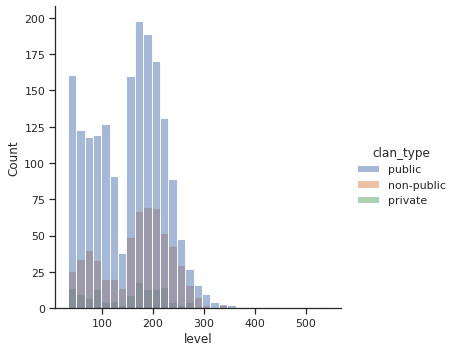

In [54]:
sns.displot(data = player_info_in_clan, x = 'level', hue = 'clan_type');

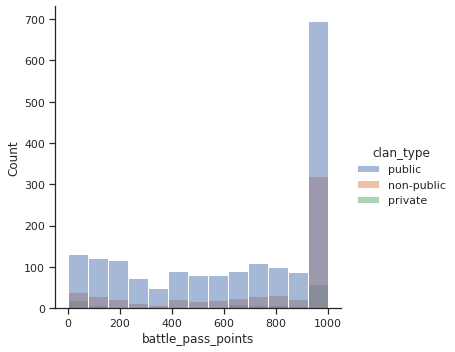

In [55]:
sns.displot(data = player_info_in_clan, x = 'battle_pass_points', hue = 'clan_type');

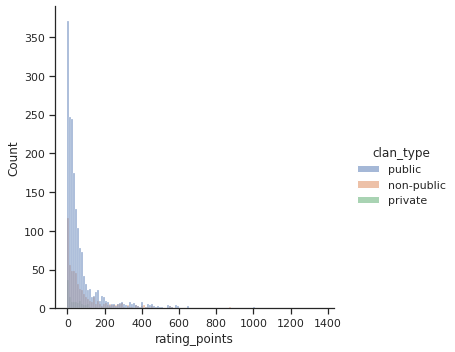

In [56]:
sns.displot(data = player_info_in_clan, x = 'rating_points', hue = 'clan_type');

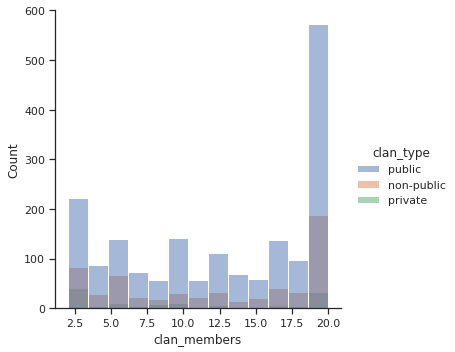

In [57]:
sns.displot(data = player_info_in_clan, x = 'clan_members', hue = 'clan_type');

Распределения типов кланов похожи между собой.

#### Итого: 
При первичном анализе мы видим, что пребывание игрока в клане и тип клана влияют на успехи игрока в игровом событии. Количество игроков в клане не показало себя влияющим фактором.